# Reading the data

In [1]:
import DataFrames, CSV

In [318]:
hw = CSV.read(
    "resources/hw_data.csv",
    DataFrames.DataFrame,
    header=false
)
;

# Normalize the data

In [17]:
import Statistics

heights = (hw[!, 1] .- Statistics.mean(hw[!, 1])) ./ Statistics.std(hw[!, 1])
weights = (hw[!, 2] .- Statistics.mean(hw[!, 2])) ./ Statistics.std(hw[!, 2])
;

# Plotting

In [7]:
import Plots

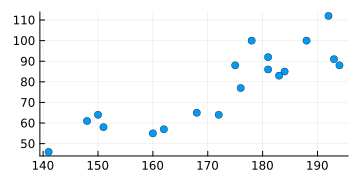

In [19]:
plot_points = Plots.scatter(
    hw[!,1],  # x
    hw[!,2],  # y
    size=(360, 180),
    label=false
)

# Solvers

## Regression

In [11]:
function get_best_weights(x, y, k)
    A = hcat([x.^j for j=0:k-1]...)
    return A \ y
end
;

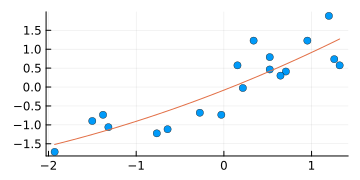

In [21]:
X = hcat(ones(size(heights)), heights, heights .^ 2)  # second order function
Y = weights

w = X \ Y
plot_points_norm = Plots.scatter(
    heights,
    weights,
    size=(360, 180),
    label=false
)
Plots.plot!(
    plot_points_norm,
    x -> w[1] + w[2] * x + w[3] * x ^ 2,
    size=(360, 180),
    label=false
)

## Bayes

In [25]:
# the gauss pdf
function pdf_gauss(z::T; σ=1) where T <: Real
    exp(- z^2 / (2σ^2)) / (σ*sqrt(2π))
end

lik_one((x, y), θ; σ=1 ) = 
    pdf_gauss(y - (x' * θ)[1]; σ=σ)

lik_data(X, y, θ; σ=1) = prod([
    lik_one((X[ii, :], y[ii]),θ; σ=σ )
    for ii = 1 : length(y)
])

sample_theta(dim, σ_0, μ_0=zeros(dim))= μ_0 + σ_0 * randn(dim, 1)
;

In [23]:
X = hcat(ones(size(heights)), heights, heights .^ 2);  # second order function
Y = weights;

In [26]:
n_sample = 500_000
θ_mean = [0, 0, 0]
θ_std  = 5
θ_dim  = size(X, 2)

θ_sam  = [
    sample_theta(θ_dim, θ_std, θ_mean) 
    for _ = 1:n_sample
]
;

In [51]:
# computing weights
sampled_weights = [lik_data(X, Y, θ; σ=14) for θ in θ_sam]

# denominator
Z = sum(w)
# numerator
num = sum(w .* θ_sam)

# the empirical mean
num ./ Z

3×1 Matrix{Float64}:
  0.02018282219142104
  0.5966657120638402
 -0.027504671747243983

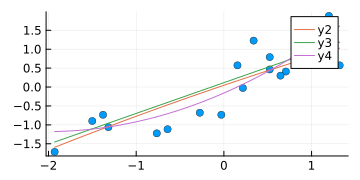

In [53]:
# extracting the likeliest functions
top = 3
functions = hcat(
    sampled_weights,
    [θ[1] for θ in θ_sam],
    [θ[2] for θ in θ_sam],
    [θ[3] for θ in θ_sam],
)
likeliest_functions = functions[sortperm(functions[:, 1], rev=true)[1:top], :]

plot_points_norm = Plots.scatter(
    heights,
    weights,
    size=(360, 180),
    label=false
)
for ii in 1 : top
    w = likeliest_functions[ii, 2:end]
    Plots.plot!(
        plot_points_norm, 
        x -> w[1] + w[2] * x + w[3] * x ^ 2
    )
end
plot_points_norm

## Second order Taylor

approximates a function in a fixed point

Example to approximate $\sqrt a$

$ f(x|a) = \frac{1}{2} \left(x^2 - a\right)^2 $

$ f'(x|a) = \frac{1}{2} * 2 * (x^2 - a) * 2 * x = 2 x (x^2 - a) $

$ f''(x|a) = 2(x^2 - a) + 2x * 2x = 2(3x^2 - a) $

Update function: $$ x_{n+1} \leftarrow x_n - \frac{f'_2(x|a) }{f''_2(x|a)} $$

$ f(x) = x - \frac{f'_2(x|a) }{f''_2(x|a)} = \frac{2}{3}(x + \frac{ax}{3x^2 - a}) $

In [89]:
update_function(x, a) = 2 / 3 * (x + (a * x) / (3 * x ^ 2 - a))

function netwon2(a, start, err=10e-6)
    val1 = update_function(start, a)
    val2 = update_function(val1, a)
    while abs(val2 - val1) > err
        val1 = val2
        val2 = update_function(val1, a)
    end
    return val2
end

netwon2 (generic function with 2 methods)

In [90]:
netwon2(2, 10)

1.414213562373095

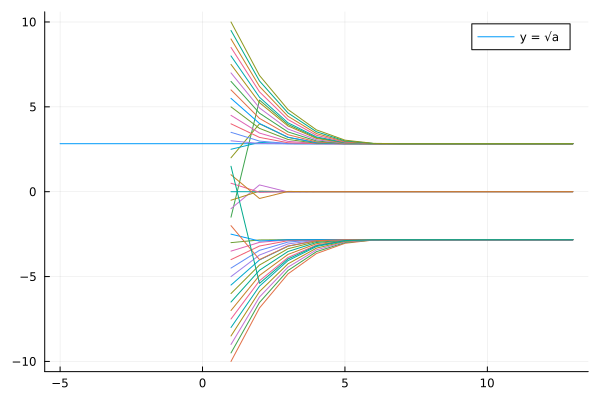

In [91]:
# Convergence graph
a = 8
function iter_f(f, n::Integer, x₀::T) where T <: Real
    vcat([x₀], [x₀=f(x₀) for _ in 1 : n]...)
end
;
p = Plots.plot((x) -> sqrt(a), label= "y = √a")
for starting_point in range(-10, 10, step=0.5)
    Plots.plot!(
        p, 
        iter_f(x -> update_function(x, a), 12, starting_point), 
        label=""
    )
end
p

## Gradient descent

In [314]:
import Statistics

predict(weights, X) = X * weights

mean_square_error(Y, y_pred) = Statistics.mean((Y - y_pred) .^ 2)

mean_square_error_der(Y, y_pred, X) = -2 * Statistics.mean(X .* (Y - y_pred), dims=1)

function train(X::Matrix{Float64}, Y::Vector{Float64}, iterations=100, learning_rate=0.1)
    weights = rand(size(X, 2))
    costs = []
    for _ in 1 : iterations
        y_pred = predict(weights, X)
        cost = mean_square_error(Y, y_pred)
        push!(costs, cost)
        weight_derivate = mean_square_error_der(Y, y_pred, X)
        weights -= learning_rate * weight_derivate'
    end
    return weights, costs 
end

train (generic function with 3 methods)

In [315]:
X = hcat(ones(size(heights)), heights, heights .^ 2)  # second order function
Y = weights

w, costs = train(X, Y)
;

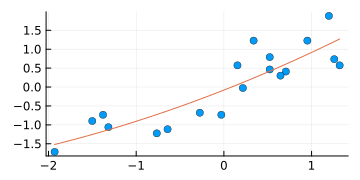

In [316]:
plot_points_norm = Plots.scatter(
    heights,
    weights,
    size=(360, 180),
    label=false
)
Plots.plot!(
    plot_points_norm,
    x -> w[1] + w[2] * x + w[3] * x ^ 2,
    size=(360, 180),
    label=false
)

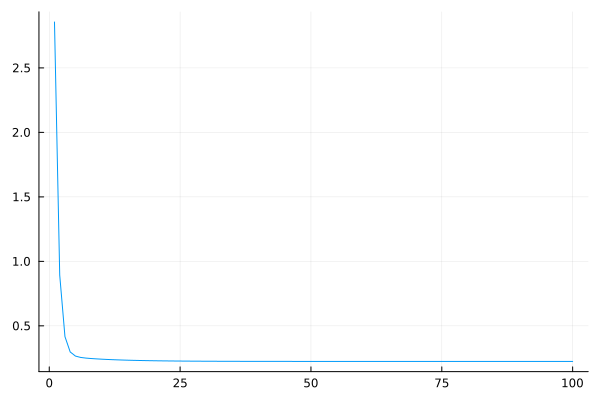

In [317]:
Plots.plot(
    1 : length(costs),
    costs,
    label=false
)

## K-Means

In [164]:
import RDatasets
iris = RDatasets.dataset("datasets", "iris"); # load the data

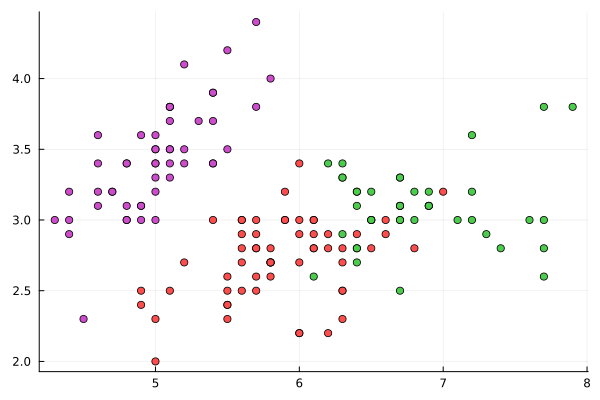

In [170]:
import Clustering

features = collect(Matrix(iris[:, 1:4])'); # features to use for clustering
K = 3
result = Clustering.kmeans(features, K, maxiter=100); # run K-means for 3 clusters

Plots.scatter(
    iris.SepalLength, 
    iris.SepalWidth, 
    marker_z=result.assignments,
    color=:lightrainbow, 
    legend=false
)

## Expectation Maximization

In [16]:
# loading the data
data = CSV.read(
    "resources/d_em.csv",
    DataFrames.DataFrame,
    header=false
)
;

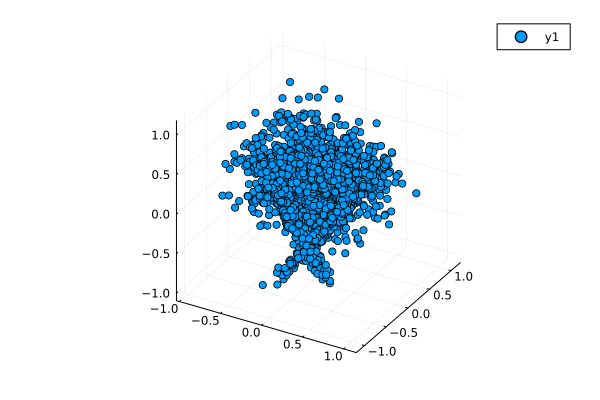

In [18]:
Plots.scatter3d(data[:, 1], data[:, 2], data[:, 3])

In [52]:
import LinearAlgebra
import Distributions
import Statistics

function gaussian_prob(element, mean, cov)
    return Distributions.pdf(
        Distributions.Normal(mean, cov),
        element
    )
end

function gaussian_fit(X, probabilities)
    prob_sum = sum(probabilities)
    mean = sum(X .* probabilities) / prob_sum
    cov = sqrt(sum(probabilities .* (X .- mean) .^ 2) / prob_sum)
    return mean, cov
end

function expectation_maximization(X, initial_probabilities, probabilities_f, fit_f)
    previous_step = []
    current_step = initial_probabilities
    while current_step != previous_step
        previous_step = current_step
        probabilities = zeros(length(X), length(probabilities_f))
        for ii in 1 : length(X)
            for jj in 1 : length(probabilities_f)
                probabilities[ii, jj] = probabilities_f[jj](X[ii], previous_step[jj]...)
            end
            probabilities[ii, :] = probabilities[ii, :] / sum(probabilities[ii, :])
        end
        current_step = []
        for jj in 1 : length(fit_f)
            push!(current_step, fit_f[jj](X, probabilities[:, jj]))
        end
    end
    return current_step
end
;

In [53]:
expectation_maximization(
    data[:, 1],
    [[rand(), rand()], [rand(), rand()], [rand(), rand()]],
    [gaussian_prob, gaussian_prob, gaussian_prob],
    [gaussian_fit, gaussian_fit, gaussian_fit]
)

3-element Vector{Any}:
 (0.014978875388922612, 0.21404979904561697)
 (-0.30488584160924925, 0.24374689481317038)
 (0.2893869463615229, 0.23415456088088166)

## PCA

In [6]:
import CSV
import DataFrames

# loading the data
test_data  = Matrix(
    CSV.read("resources/emnist_test.csv", DataFrames.DataFrame, header=false))

x_te0  = test_data[:,2:end]
y_te0  = test_data[:,1]

# decresing the set of test data
n_test = 8000
x_test = Float64.(x_te0[1:n_test,:])
y_test = Float64.(y_te0[1:n_test,:])

# data dimensions
dim_data = size(x_test, 2)
dim_sq  = Int(round(sqrt(dim_data)))
;

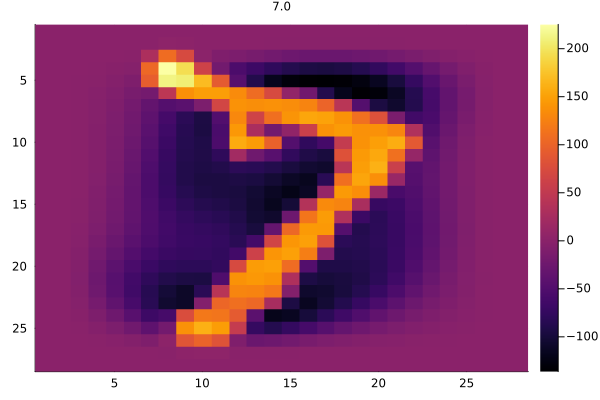

In [8]:
import Plots

# computing the mean
mean_x = sum(x_test, dims=1) / n_test

x_2 = x_test .- mean_x

ii = 6545
Plots.heatmap(
    reshape(x_2[ii,:], (dim_sq,dim_sq)),
    title=string(y_test[ii]),
    yflip = true,
    titlefont=Plots.font(8)
)

In [10]:
import LinearAlgebra

cov_2 = x_2' * x_2 / n_test

dig_Eig = LinearAlgebra.eigen(cov_2; sortby= x -> -x);

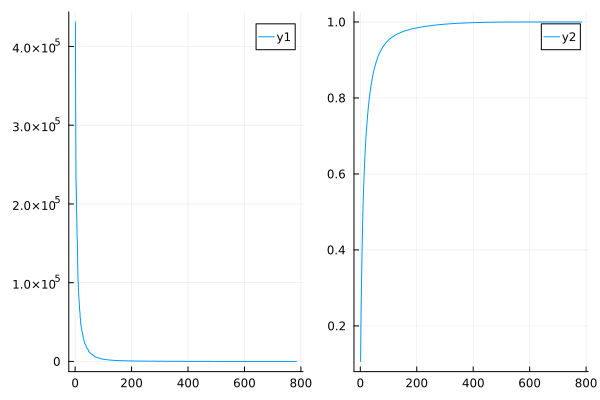

In [11]:
p = Plots.plot(layout=(1,2))
Plots.plot!(p[1],dig_Eig.values)
c = cumsum(dig_Eig.values)
Plots.plot!(p[2],c/c[end])

In [12]:
K = 160
c[K]/c[end]

0.9769546225842954

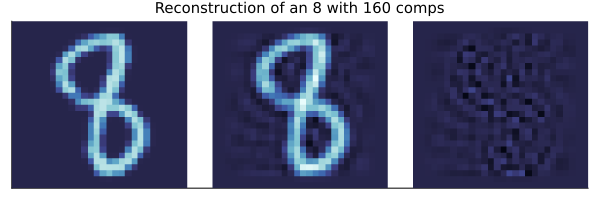

In [14]:
P = dig_Eig.vectors[:,1:K]

p = Plots.plot(size=(600,200))
ii = 6548
z = P'*x_2[ii,:]
c_rec = P*z
e_rec = x_2[ii,:] - c_rec

Plots.heatmap!(p,
    hcat(
        # initial
        reshape(mean_x' + x_2[ii,:], (dim_sq,dim_sq) ), 
        NaN*ones(28,4),
        # with reduced features
        reshape(mean_x' + c_rec, (dim_sq,dim_sq)), 
        NaN*ones(28,4),
        # data lost
        reshape(e_rec, (dim_sq,dim_sq))
    ),
    title="Reconstruction of an $(Int8(y_test[ii])) with $K comps",
    yflip=true,
    titlefont=Plots.font(10),
    colorbar=false,
    fillcolor=:ice,
    xtick=[],
    ytick=[]
)